# Multimodal Data Fusion and Advanced Modeling

This notebook merges our three primary datasets:
1. Bike Data (Citi Bike usage)
2. Weather Data (hourly weather conditions)
3. Traffic Data (vehicle counts from ATR)

Then we'll build advanced machine learning and deep learning models to predict bike demand using features from all datasets.

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import joblib
from tqdm.notebook import tqdm

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

%pip install lightgbm
# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
import xgboost as xgb
import lightgbm as lgb

# Deep Learning Models
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Input
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available. Deep learning models will be skipped.")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Configure environment
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


## 1. Load the Engineered Datasets

Let's load the three engineered datasets we've prepared in previous notebooks.

In [4]:
# Define the data directory
final_data_dir = '../data/final/'

# Load bike data
bike_data_path = os.path.join(final_data_dir, 'citibike_engineered_20250719_161523.csv')
if os.path.exists(bike_data_path):
    bike_df = pd.read_csv(bike_data_path)
    print(f"Loaded bike data with {bike_df.shape[0]} rows and {bike_df.shape[1]} columns")
else:
    print(f"Bike data not found at {bike_data_path}")
    bike_df = None

# Load weather data
weather_data_path = os.path.join(final_data_dir, 'weather_engineered.csv')
if os.path.exists(weather_data_path):
    weather_df = pd.read_csv(weather_data_path)
    print(f"Loaded weather data with {weather_df.shape[0]} rows and {weather_df.shape[1]} columns")
else:
    print(f"Weather data not found at {weather_data_path}")
    weather_df = None

# Load traffic data
traffic_data_path = os.path.join(final_data_dir, 'traffic_engineered.csv')
if os.path.exists(traffic_data_path):
    traffic_df = pd.read_csv(traffic_data_path)
    print(f"Loaded traffic data with {traffic_df.shape[0]} rows and {traffic_df.shape[1]} columns")
else:
    print(f"Traffic data not found at {traffic_data_path}")
    traffic_df = None

# Check which datasets are available
available_data = []
if bike_df is not None:
    available_data.append("bike")
if weather_df is not None:
    available_data.append("weather")
if traffic_df is not None:
    available_data.append("traffic")

print(f"\nAvailable datasets: {', '.join(available_data)}")

C:\Users\21654\AppData\Local\Temp\ipykernel_6308\1054858368.py:7: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  bike_df = pd.read_csv(bike_data_path)


Loaded bike data with 35000730 rows and 25 columns
Loaded weather data with 8760 rows and 28 columns
Loaded weather data with 8760 rows and 28 columns
Loaded traffic data with 71328 rows and 43 columns

Available datasets: bike, weather, traffic
Loaded traffic data with 71328 rows and 43 columns

Available datasets: bike, weather, traffic


## 2. Prepare Data for Merging

Before merging, we need to ensure that all datasets have compatible date/time formats and appropriate keys for joining.

In [6]:
def prepare_bike_data(df):
    """Prepare bike data for merging"""
    if df is None:
        return None
    
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Ensure datetime columns are in the right format
    datetime_cols = ['started_at', 'ended_at']
    for col in datetime_cols:
        if col in df_copy.columns:
            df_copy[col] = pd.to_datetime(df_copy[col])
    
    # Create date and hour columns for merging
    if 'started_at' in df_copy.columns:
        df_copy['date'] = pd.to_datetime(df_copy['started_at']).dt.date
        df_copy['hour'] = pd.to_datetime(df_copy['started_at']).dt.hour
        df_copy['datetime_hour'] = pd.to_datetime(df_copy['started_at']).dt.floor('H')
    
    # Aggregate by station, date, and hour to get demand counts
    if all(col in df_copy.columns for col in ['start_station_id', 'date', 'hour']):
        demand_df = df_copy.groupby(['start_station_id', 'date', 'hour']).size().reset_index(name='demand_count')
        
        # Convert date to datetime - Fix by using string format first to avoid dtype issues
        demand_df['date'] = pd.to_datetime(demand_df['date'].astype(str))
        demand_df['datetime_hour'] = pd.to_datetime(
            demand_df['date'].dt.strftime('%Y-%m-%d') + ' ' + demand_df['hour'].astype(str) + ':00:00'
        )
        
        # Compute statistics by station and hour
        # Get mean features by station and hour
        station_hour_features = ['ride_distance_km', 'ride_duration', 'is_weekend', 'is_peak_hour']
        avail_features = [col for col in station_hour_features if col in df_copy.columns]
        
        if avail_features:
            for feature in avail_features:
                if df_copy[feature].dtype in ['int64', 'float64']:
                    feature_agg = df_copy.groupby(['start_station_id', 'date', 'hour'])[feature].mean().reset_index()
                    # Ensure date is in datetime format for feature_agg as well
                    feature_agg['date'] = pd.to_datetime(feature_agg['date'].astype(str))
                    demand_df = demand_df.merge(
                        feature_agg, 
                        on=['start_station_id', 'date', 'hour'], 
                        how='left'
                    )
        
        return demand_df
    
    return df_copy

def prepare_weather_data(df):
    """Prepare weather data for merging"""
    if df is None:
        return None
    
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Ensure date column is in datetime format
    if 'date' in df_copy.columns:
        df_copy['date'] = pd.to_datetime(df_copy['date'])
        
        # Create datetime_hour for merging - use consistent formatting
        if 'hour' in df_copy.columns:
            df_copy['datetime_hour'] = pd.to_datetime(
                df_copy['date'].dt.strftime('%Y-%m-%d') + ' ' + df_copy['hour'].astype(str) + ':00:00'
            )
    
    return df_copy

def prepare_traffic_data(df):
    """Prepare traffic data for merging"""
    if df is None:
        return None
    
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Ensure datetime columns are in the right format
    if 'datetime_hour' in df_copy.columns:
        df_copy['datetime_hour'] = pd.to_datetime(df_copy['datetime_hour'])
        df_copy['date'] = df_copy['datetime_hour'].dt.date
        df_copy['hour'] = df_copy['datetime_hour'].dt.hour
    elif all(col in df_copy.columns for col in ['Yr', 'M', 'D', 'HH']):
        # Create datetime from components
        df_copy['date'] = pd.to_datetime(
            df_copy['Yr'].astype(str) + '-' + 
            df_copy['M'].astype(str).str.zfill(2) + '-' + 
            df_copy['D'].astype(str).str.zfill(2)
        )
        df_copy['hour'] = df_copy['HH']
        df_copy['datetime_hour'] = pd.to_datetime(
            df_copy['date'].dt.strftime('%Y-%m-%d') + ' ' + df_copy['hour'].astype(str) + ':00:00'
        )
    
    # Aggregate by borough, street, date, and hour to get traffic volume
    if all(col in df_copy.columns for col in ['Boro', 'street', 'date', 'hour', 'Vol']):
        traffic_agg = df_copy.groupby(['Boro', 'street', 'date', 'hour'])['Vol'].mean().reset_index()
        # Convert date to datetime with string conversion to ensure consistent format
        traffic_agg['date'] = pd.to_datetime(traffic_agg['date'].astype(str))
        traffic_agg['datetime_hour'] = pd.to_datetime(
            traffic_agg['date'].dt.strftime('%Y-%m-%d') + ' ' + traffic_agg['hour'].astype(str) + ':00:00'
        )
        return traffic_agg
    
    return df_copy

# Prepare each dataset
bike_prepared = prepare_bike_data(bike_df)
weather_prepared = prepare_weather_data(weather_df)
traffic_prepared = prepare_traffic_data(traffic_df)

# Display sample of each prepared dataset
print("\nPrepared Bike Data:")
if bike_prepared is not None:
    print(bike_prepared.head())
    print(f"Shape: {bike_prepared.shape}")
    
print("\nPrepared Weather Data:")
if weather_prepared is not None:
    print(weather_prepared.head())
    print(f"Shape: {weather_prepared.shape}")
    
print("\nPrepared Traffic Data:")
if traffic_prepared is not None:
    print(traffic_prepared.head())
    print(f"Shape: {traffic_prepared.shape}")

C:\Users\21654\AppData\Local\Temp\ipykernel_6308\4054834239.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_copy['datetime_hour'] = pd.to_datetime(df_copy['started_at']).dt.floor('H')



Prepared Bike Data:
  start_station_id       date  hour  demand_count       datetime_hour  \
0          2733.03 2023-01-01    13             1 2023-01-01 13:00:00   
1          2733.03 2023-01-01    15             1 2023-01-01 15:00:00   
2          2733.03 2023-01-01    17             1 2023-01-01 17:00:00   
3          2733.03 2023-01-01    21             1 2023-01-01 21:00:00   
4          2733.03 2023-01-02    14             1 2023-01-02 14:00:00   

   ride_distance_km  ride_duration  is_weekend  is_peak_hour  
0          4.227310      16.093767         1.0           0.0  
1          6.798890      41.582267         1.0           0.0  
2          1.567518      10.354667         1.0           1.0  
3          4.747967      13.967933         1.0           0.0  
4          3.677559      17.590850         0.0           0.0  
Shape: (10855404, 9)

Prepared Weather Data:
                       date  temperature_2m  wind_speed_10m  rain  snowfall  \
0 2023-01-01 04:00:00+00:00         10

## 3. Merge the Datasets

Now we'll merge the prepared datasets based on datetime_hour and location (where applicable).

In [7]:
def merge_datasets(bike_df, weather_df, traffic_df):
    """Merge the prepared datasets"""
    # Start with bike data as the base
    if bike_df is None:
        return None
    
    merged_df = bike_df.copy()
    
    # Merge with weather data on datetime_hour
    if weather_df is not None:
        # Select important weather features to include
        weather_features = [
            'datetime_hour', 'temperature_2m', 'precipitation', 'wind_speed_10m',
            'weather_severity', 'is_good_biking_weather', 'has_precipitation',
            'is_comfortable_temp', 'is_windy', 'season'
        ]
        
        # Only include columns that exist in the weather dataframe
        avail_weather_features = [col for col in weather_features if col in weather_df.columns]
        
        if 'datetime_hour' in avail_weather_features:
            weather_subset = weather_df[avail_weather_features]
            
            # Merge on datetime_hour
            merged_df = merged_df.merge(
                weather_subset,
                on='datetime_hour',
                how='left',
                suffixes=('', '_weather')
            )
            
            print(f"Merged with weather data. New shape: {merged_df.shape}")
    
    # Merge with traffic data - this is more complex as we need to match locations
    if traffic_df is not None:
        # We might need a more sophisticated approach to match bike stations with traffic locations
        # For now, we'll just aggregate traffic data by datetime_hour across all locations
        if 'datetime_hour' in traffic_df.columns and 'Vol' in traffic_df.columns:
            # Aggregate traffic volume by datetime_hour
            traffic_by_hour = traffic_df.groupby('datetime_hour')['Vol'].agg(
                ['mean', 'max', 'sum', 'count']
            ).reset_index()
            
            traffic_by_hour.columns = ['datetime_hour', 'traffic_mean', 'traffic_max', 
                                       'traffic_sum', 'traffic_count']
            
            # Merge on datetime_hour
            merged_df = merged_df.merge(
                traffic_by_hour,
                on='datetime_hour',
                how='left',
                suffixes=('', '_traffic')
            )
            
            print(f"Merged with traffic data. New shape: {merged_df.shape}")
    
    # Handle missing values
    # For now, we'll drop rows with missing values, but in a real-world scenario,
    # you might want to use imputation techniques
    missing_count = merged_df.isnull().sum().sum()
    if missing_count > 0:
        print(f"Dataset contains {missing_count} missing values.")
        
        # Show columns with missing values
        missing_cols = merged_df.columns[merged_df.isnull().any()].tolist()
        print(f"Columns with missing values: {missing_cols}")
        
        # Drop rows with missing values
        merged_df_cleaned = merged_df.dropna()
        print(f"Shape after dropping missing values: {merged_df_cleaned.shape}")
        
        return merged_df_cleaned
    
    return merged_df

# Merge the prepared datasets
merged_data = merge_datasets(bike_prepared, weather_prepared, traffic_prepared)

if merged_data is not None:
    print("\nMerged Data Sample:")
    print(merged_data.head())
    print(f"\nMerged Data Shape: {merged_data.shape}")
    print(f"\nMerged Data Columns: {merged_data.columns.tolist()}")
    
    # Count of unique values per column
    print("\nUnique values per column:")
    for col in merged_data.columns:
        if merged_data[col].dtype != 'object':
            print(f"{col}: {merged_data[col].nunique()} unique values")
else:
    print("Failed to merge datasets. Please check the preparation steps.")

Merged with weather data. New shape: (10855404, 18)
Merged with traffic data. New shape: (10855404, 22)
Merged with traffic data. New shape: (10855404, 22)
Dataset contains 18258740 missing values.
Dataset contains 18258740 missing values.
Columns with missing values: ['ride_distance_km', 'temperature_2m', 'precipitation', 'wind_speed_10m', 'weather_severity', 'is_good_biking_weather', 'has_precipitation', 'is_comfortable_temp', 'is_windy', 'season', 'traffic_mean', 'traffic_max', 'traffic_sum', 'traffic_count']
Columns with missing values: ['ride_distance_km', 'temperature_2m', 'precipitation', 'wind_speed_10m', 'weather_severity', 'is_good_biking_weather', 'has_precipitation', 'is_comfortable_temp', 'is_windy', 'season', 'traffic_mean', 'traffic_max', 'traffic_sum', 'traffic_count']
Shape after dropping missing values: (6298240, 22)

Merged Data Sample:
   start_station_id       date  hour  demand_count       datetime_hour  \
16          2733.03 2023-01-06     8             1 2023-01

In [8]:
import os
from datetime import datetime

# Create output directory if it doesn't exist
final_data_dir = '../data/final/'
os.makedirs(final_data_dir, exist_ok=True)

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the merged dataset
if merged_data is not None:
    merged_data_path = os.path.join(final_data_dir, f'merged_dataset_{timestamp}.csv')
    merged_data.to_csv(merged_data_path, index=False)
    print(f"Merged dataset saved to: {merged_data_path}")
    print(f"Dataset shape: {merged_data.shape}")



Merged dataset saved to: ../data/final/merged_dataset_20250720_170853.csv
Dataset shape: (6298240, 22)


## 4. Feature Engineering for Merged Data

Let's create additional features based on the relationships between the datasets.

In [9]:
def engineer_merged_features(df):
    """Create new features from the merged dataset"""
    if df is None:
        return None
    
    # Make a copy to avoid modifying the original
    df_copy = df.copy()
    
    # 1. Weather-Bike interaction features
    if all(col in df_copy.columns for col in ['temperature_2m', 'demand_count']):
        # Temperature demand interaction
        df_copy['temp_demand_ratio'] = df_copy['demand_count'] / df_copy['temperature_2m'].clip(lower=1)
    
    if all(col in df_copy.columns for col in ['has_precipitation', 'demand_count']):
        # Calculate demand ratio between precipitation and no precipitation
        precip_demand = df_copy[df_copy['has_precipitation'] == 1]['demand_count'].mean()
        no_precip_demand = df_copy[df_copy['has_precipitation'] == 0]['demand_count'].mean()
        
        if no_precip_demand > 0:
            precip_effect = precip_demand / no_precip_demand
            print(f"Precipitation effect on demand: {precip_effect:.2f}")
    
    # 2. Traffic-Bike interaction features
    if all(col in df_copy.columns for col in ['traffic_mean', 'demand_count']):
        # Traffic congestion effect on bike usage
        df_copy['traffic_bike_ratio'] = df_copy['demand_count'] / df_copy['traffic_mean'].clip(lower=1)
    
    # 3. Combined weather and traffic effect on bike demand
    if all(col in df_copy.columns for col in ['weather_severity', 'traffic_mean']):
        # Combined effect score (higher means worse conditions)
        df_copy['combined_effect_score'] = (
            df_copy['weather_severity'] * 0.7 + 
            (df_copy['traffic_mean'] / df_copy['traffic_mean'].max()) * 0.3
        ).clip(0, 10)
    
    # 4. Time-based features
    if 'datetime_hour' in df_copy.columns:
        # Extract more time components
        df_copy['day_of_week'] = pd.to_datetime(df_copy['datetime_hour']).dt.dayofweek
        df_copy['month'] = pd.to_datetime(df_copy['datetime_hour']).dt.month
        df_copy['day'] = pd.to_datetime(df_copy['datetime_hour']).dt.day
        
        # Create cyclical features for hour, day of week, month
        df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
        df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)
        df_copy['day_of_week_sin'] = np.sin(2 * np.pi * df_copy['day_of_week'] / 7)
        df_copy['day_of_week_cos'] = np.cos(2 * np.pi * df_copy['day_of_week'] / 7)
        df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
        df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)
    
    # 5. Lagged features (if time series data is available)
    # Group by station and sort by datetime
    if all(col in df_copy.columns for col in ['start_station_id', 'datetime_hour', 'demand_count']):
        # Sort data
        df_copy = df_copy.sort_values(['start_station_id', 'datetime_hour'])
        
        # Create station groups
        station_groups = df_copy.groupby('start_station_id')
        
        # Create lagged demand features
        df_copy['demand_lag_1h'] = station_groups['demand_count'].shift(1)
        df_copy['demand_lag_2h'] = station_groups['demand_count'].shift(2)
        df_copy['demand_lag_24h'] = station_groups['demand_count'].shift(24)  # Same hour previous day
        
        # Create rolling average features
        df_copy['demand_rolling_3h'] = station_groups['demand_count'].transform(
            lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
        )
        df_copy['demand_rolling_24h'] = station_groups['demand_count'].transform(
            lambda x: x.shift(1).rolling(window=24, min_periods=1).mean()
        )
    
    # Drop rows with NaN values from lagged features
    df_copy = df_copy.dropna()
    
    return df_copy

# Engineer features for the merged dataset
engineered_data = engineer_merged_features(merged_data)

if engineered_data is not None:
    print("\nEngineered Data Sample:")
    print(engineered_data.head())
    print(f"\nEngineered Data Shape: {engineered_data.shape}")
    print(f"\nNew Features Added: {set(engineered_data.columns) - set(merged_data.columns)}")
else:
    print("Failed to engineer features. Please check the merged dataset.")

Precipitation effect on demand: 0.87

Engineered Data Sample:
   start_station_id       date  hour  demand_count       datetime_hour  \
56          2733.03 2023-01-24    21             1 2023-01-24 21:00:00   
57          2733.03 2023-01-25     7             1 2023-01-25 07:00:00   
58          2733.03 2023-01-25     8             1 2023-01-25 08:00:00   
59          2733.03 2023-01-25    14             1 2023-01-25 14:00:00   
60          2733.03 2023-01-25    16             1 2023-01-25 16:00:00   

    ride_distance_km  ride_duration  is_weekend  is_peak_hour  temperature_2m  \
56          5.233720      15.896467         0.0           0.0          5.7225   
57          1.662439       8.121867         0.0           1.0         -1.6275   
58          0.386621       2.576200         0.0           1.0         -1.7775   
59          1.178464      15.712133         0.0           0.0          0.3725   
60         13.980894      95.406383         0.0           1.0          2.3225   

    pr

## 5. Exploratory Data Analysis on Merged Dataset

Let's visualize the relationships between our key features across the merged datasets.

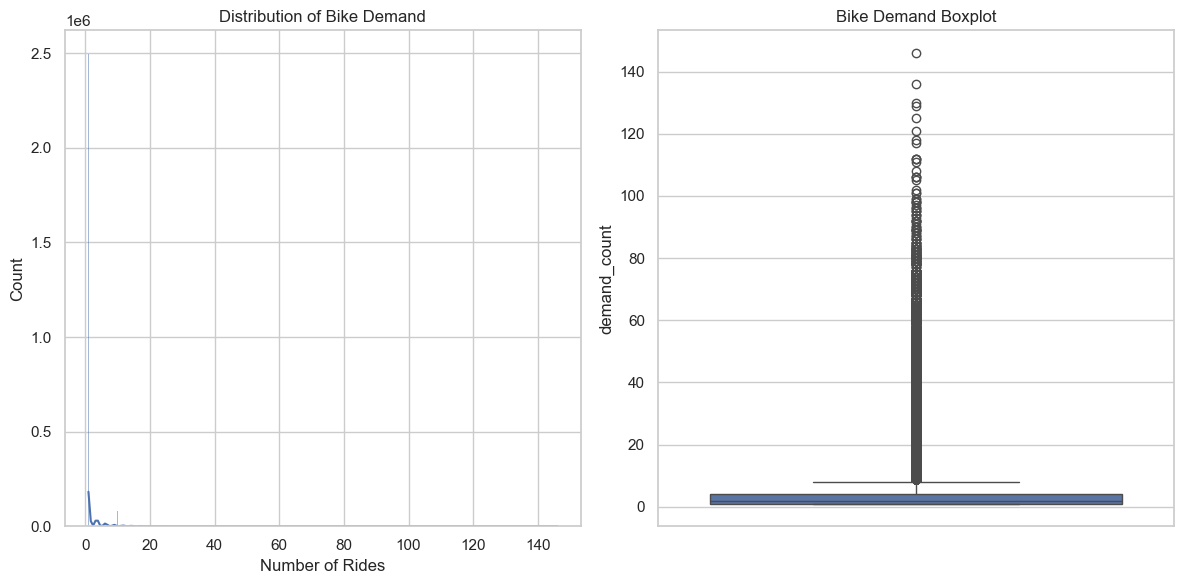

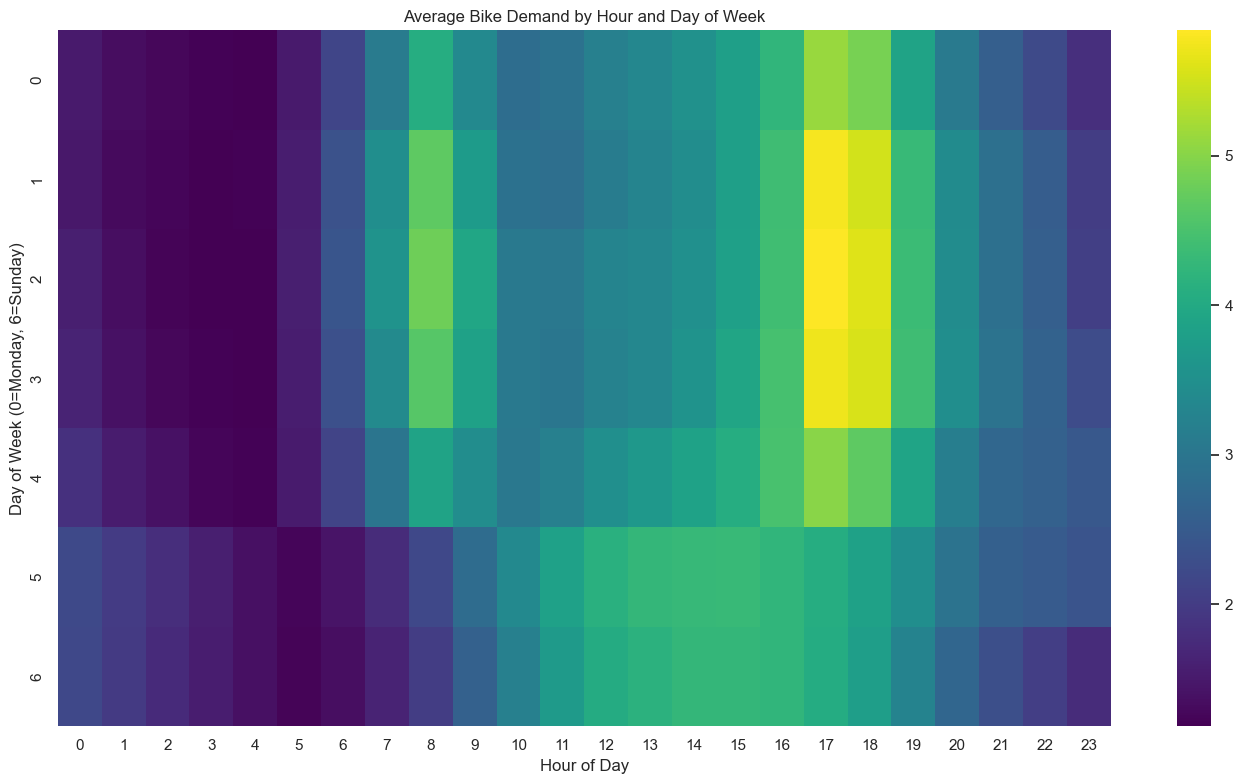

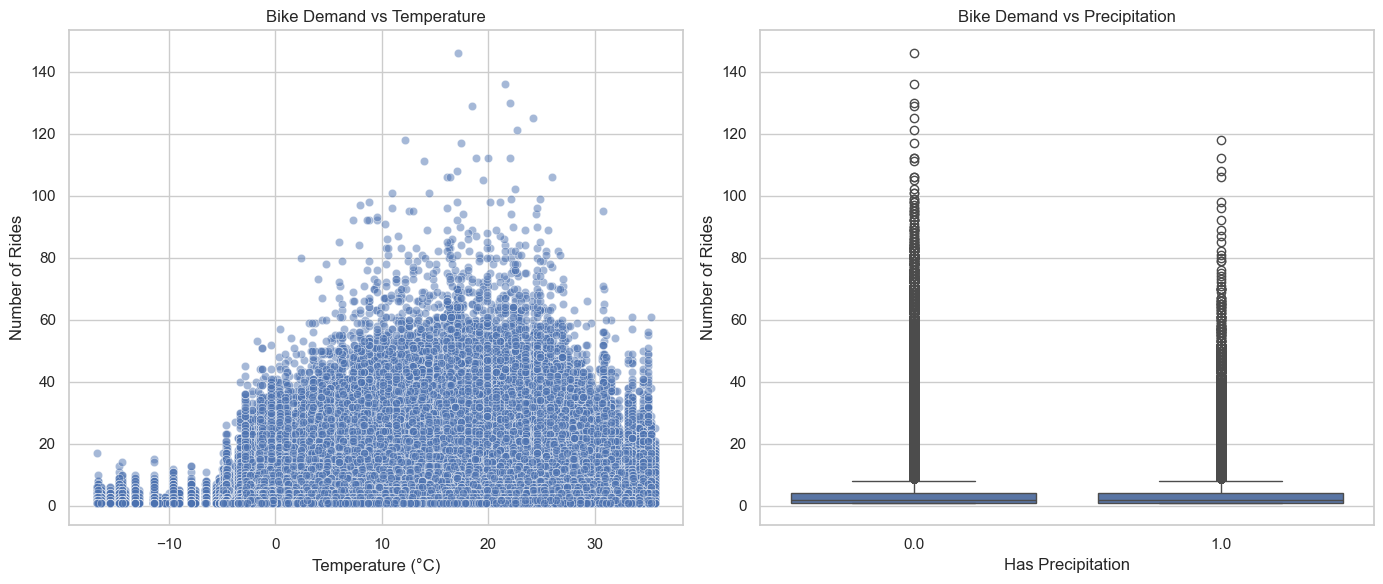

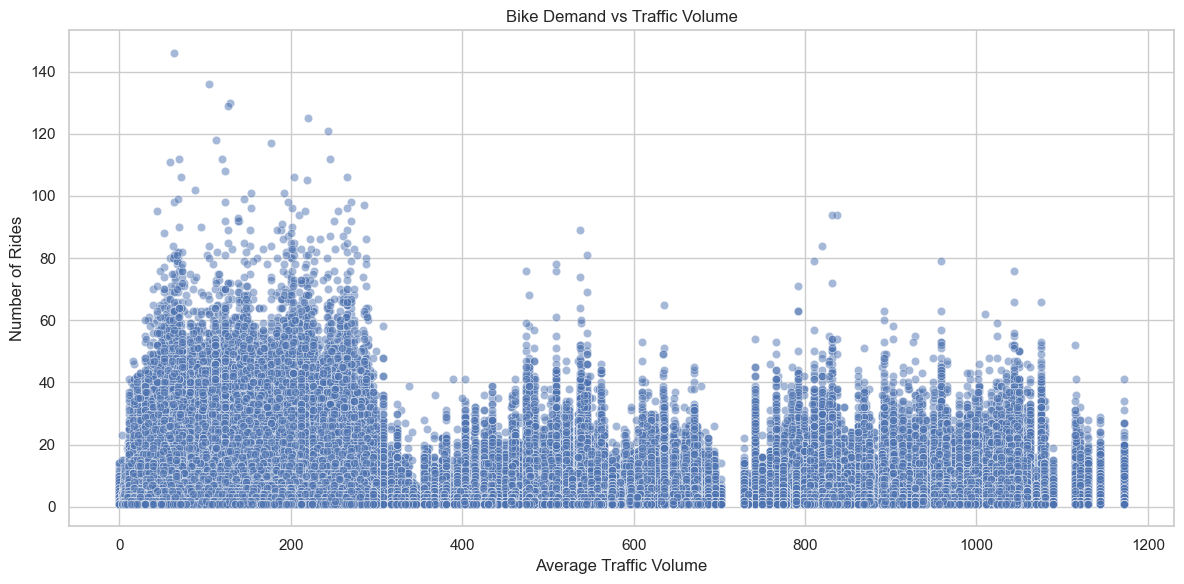

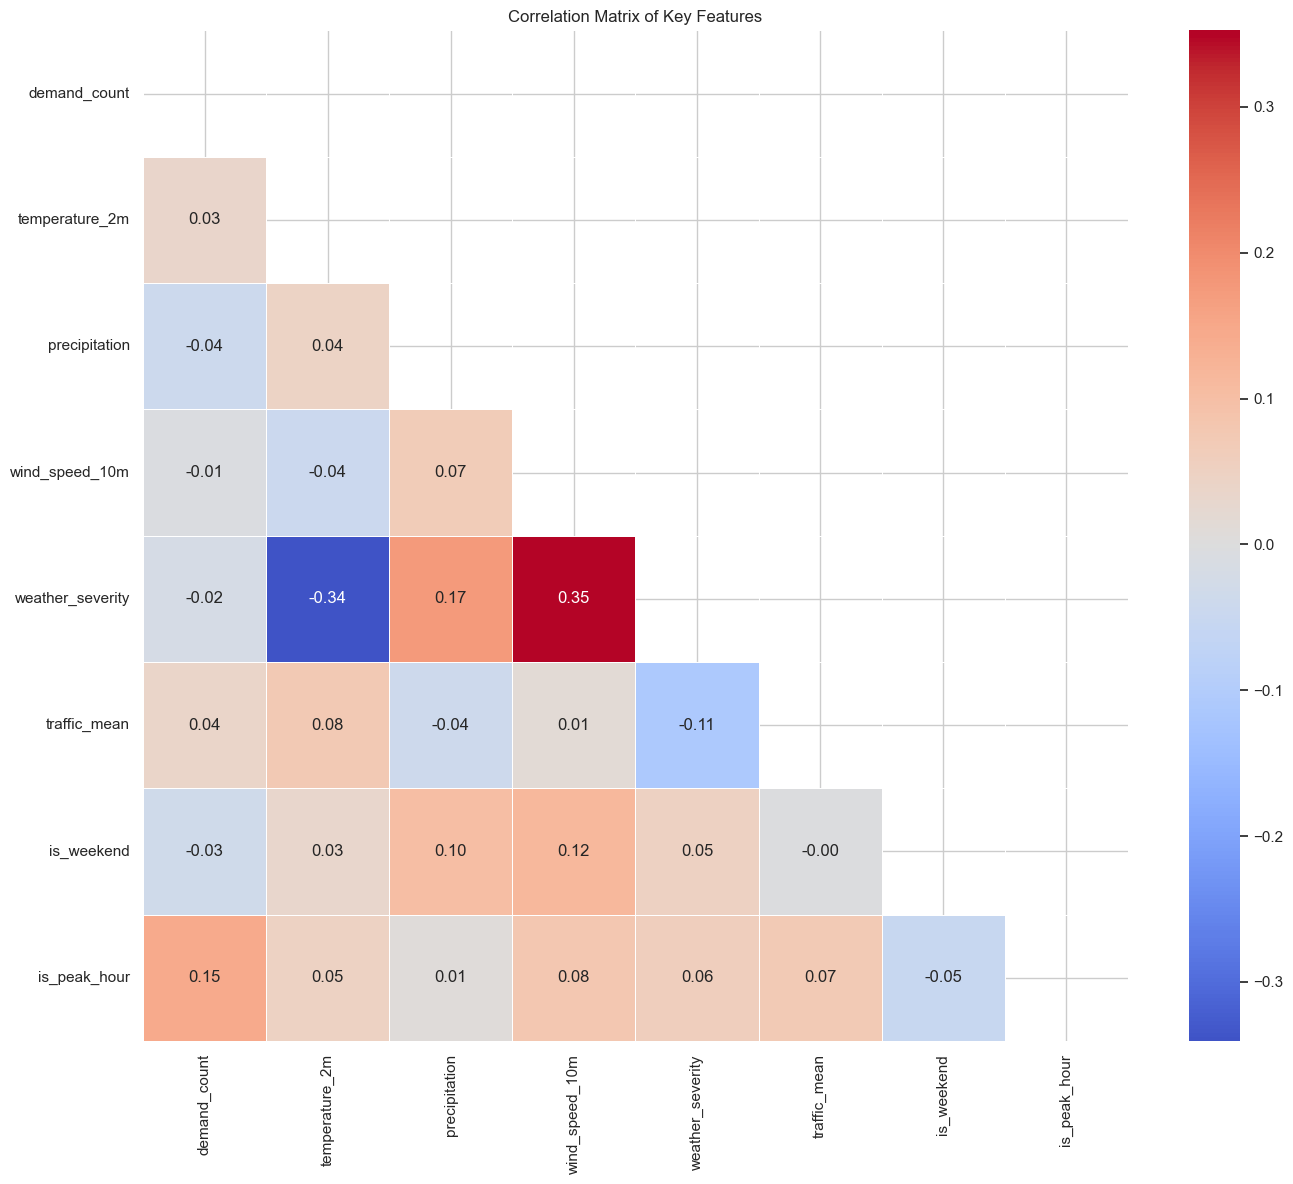

In [10]:
def explore_merged_data(df):
    """Perform exploratory data analysis on the merged dataset"""
    if df is None:
        return
    
    # 1. Distribution of the target variable (demand_count)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['demand_count'], kde=True)
    plt.title('Distribution of Bike Demand')
    plt.xlabel('Number of Rides')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['demand_count'])
    plt.title('Bike Demand Boxplot')
    plt.tight_layout()
    plt.show()
    
    # 2. Demand by hour and day of week
    if all(col in df.columns for col in ['hour', 'day_of_week', 'demand_count']):
        pivot_hour_dow = df.groupby(['day_of_week', 'hour'])['demand_count'].mean().unstack()
        
        plt.figure(figsize=(14, 8))
        sns.heatmap(pivot_hour_dow, cmap='viridis', annot=False)
        plt.title('Average Bike Demand by Hour and Day of Week')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week (0=Monday, 6=Sunday)')
        plt.tight_layout()
        plt.show()
    
    # 3. Weather impact on bike demand
    if all(col in df.columns for col in ['temperature_2m', 'demand_count']):
        plt.figure(figsize=(14, 6))
        
        plt.subplot(1, 2, 1)
        sns.scatterplot(x='temperature_2m', y='demand_count', data=df, alpha=0.5)
        plt.title('Bike Demand vs Temperature')
        plt.xlabel('Temperature (°C)')
        plt.ylabel('Number of Rides')
        
        if 'has_precipitation' in df.columns:
            plt.subplot(1, 2, 2)
            sns.boxplot(x='has_precipitation', y='demand_count', data=df)
            plt.title('Bike Demand vs Precipitation')
            plt.xlabel('Has Precipitation')
            plt.ylabel('Number of Rides')
        
        plt.tight_layout()
        plt.show()
    
    # 4. Traffic impact on bike demand
    if all(col in df.columns for col in ['traffic_mean', 'demand_count']):
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x='traffic_mean', y='demand_count', data=df, alpha=0.5)
        plt.title('Bike Demand vs Traffic Volume')
        plt.xlabel('Average Traffic Volume')
        plt.ylabel('Number of Rides')
        plt.tight_layout()
        plt.show()
    
    # 5. Correlation matrix of numerical features
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numerical_cols) > 0:
        # Select subset of important features if there are too many
        if len(numerical_cols) > 15:
            key_features = [
                'demand_count', 'temperature_2m', 'precipitation', 'wind_speed_10m',
                'weather_severity', 'traffic_mean', 'is_weekend', 'is_peak_hour',
                'hour', 'day_of_week', 'month'
            ]
            available_key_features = [col for col in key_features if col in numerical_cols]
            corr_matrix = df[available_key_features].corr()
        else:
            corr_matrix = df[numerical_cols].corr()
        
        plt.figure(figsize=(14, 12))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                    fmt='.2f', linewidths=0.5)
        plt.title('Correlation Matrix of Key Features')
        plt.tight_layout()
        plt.show()

# Explore the engineered data
explore_merged_data(engineered_data)